#### Library

In [1]:
import os
import cv2
import json
import numpy as np
import tensorflow as tf
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

2023-11-13 16:17:38.993424: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-13 16:17:39.039187: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-13 16:17:39.039219: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-13 16:17:39.039247: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-13 16:17:39.047327: I tensorflow/core/platform/cpu_feature_g

#### Frame Extraction from Videos

In [2]:
import cv2
import os

# Constants
DATA_FOLDER = '/home/sahit/dataset'
TRAIN_FOLDER = os.path.join(DATA_FOLDER, 'train_sample_videos')  # Directory containing training data
TEST_FOLDER = os.path.join(DATA_FOLDER, 'test_videos')    # Directory containing test data
FRAME_INTERVAL = 5  # Extract every 5th frame

def extract_frames(video_path, output_folder):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Save frame to the output folder
        if frame_count % FRAME_INTERVAL == 0:
            frame_filename = os.path.join(output_folder, f'frame_{frame_count}.jpg')
            cv2.imwrite(frame_filename, frame)
        
        frame_count += 1

    cap.release()

# Extract frames from training videos
for video_filename in os.listdir(TRAIN_FOLDER):
    video_path = os.path.join(TRAIN_FOLDER, video_filename)
    output_folder = os.path.join(DATA_FOLDER, 'train_frames', os.path.splitext(video_filename)[0])
    os.makedirs(output_folder, exist_ok=True)
    extract_frames(video_path, output_folder)

# Extract frames from test videos
for video_filename in os.listdir(TEST_FOLDER):
    video_path = os.path.join(TEST_FOLDER, video_filename)
    output_folder = os.path.join(DATA_FOLDER, 'test_frames', os.path.splitext(video_filename)[0])
    os.makedirs(output_folder, exist_ok=True)
    extract_frames(video_path, output_folder)


FileNotFoundError: [Errno 2] No such file or directory: '/home/sahit/dataset/train_sample_videos'

#### Loading Data

In [3]:
# Constants
frame_size = (128, 128)
batch_size = 32
epochs = 100

# Paths
data_dir = r'/home/ubuntu/newml'
json_file = r'/home/ubuntu/newml/train_sample_videos/metadata.json'

# Load the JSON file to get video labels and splits
with open(json_file, 'r') as json_data:
    annotations = json.load(json_data)

# Define a mapping for labels
label_mapping = {'REAL': 0, 'FAKE': 1}

# Create directories to store extracted frames
train_frames_dir = os.path.join(data_dir, 'train_frames')
os.makedirs(train_frames_dir, exist_ok=True)

#### Pre Processing

In [4]:
# Extract frames and preprocess data
X = []
y = []

for video_filename, metadata in annotations.items():
    video_path = os.path.join(data_dir, video_filename)
    output_folder = train_frames_dir
    # Extract frames (you can uncomment your frame extraction code if needed)

    # Load and preprocess frames
    for frame_filename in os.listdir(os.path.join(output_folder, os.path.splitext(video_filename)[0])):
        frame_path = os.path.join(output_folder, os.path.splitext(video_filename)[0], frame_filename)
        frame = cv2.imread(frame_path)
        frame = cv2.resize(frame, frame_size)
        frame = frame / 255.0
        X.append(frame)
        y.append(label_mapping[metadata['label']])

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

KeyboardInterrupt: 

#### CNN Model

In [7]:
from keras import regularizers

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the CNN model with L2 regularization and dropout
model = tf.keras.Sequential([
    layers.Conv2D(256, (3, 3), activation='relu', input_shape=(frame_size[0], frame_size[1], 3),
                  kernel_regularizer=regularizers.l2(0.0001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', input_shape=(frame_size[0], frame_size[1], 3),
                  kernel_regularizer=regularizers.l2(0.0001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(frame_size[0], frame_size[1], 3),
                  kernel_regularizer=regularizers.l2(0.0001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(frame_size[0], frame_size[1], 3),
                  kernel_regularizer=regularizers.l2(0.0001)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
     layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dropout(0.5),  

    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dropout(0.5),  
    layers.Dense(1, activation='sigmoid')
])

In [8]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss:{test_loss * 100:.2f}%")
print(f"Test Accuracy:{test_accuracy * 100:.2f}%")

Epoch 1/100
600/600 [==============================] - 49s 81ms/step - loss: 0.5204 - accuracy: 0.7990 - val_loss: 0.4870 - val_accuracy: 0.8037
Epoch 2/100
600/600 [==============================] - 46s 76ms/step - loss: 0.4694 - accuracy: 0.8085 - val_loss: 0.4370 - val_accuracy: 0.8037
Epoch 3/100
600/600 [==============================] - 46s 76ms/step - loss: 0.4397 - accuracy: 0.8090 - val_loss: 0.4157 - val_accuracy: 0.8037
Epoch 4/100
600/600 [==============================] - 46s 76ms/step - loss: 0.4195 - accuracy: 0.8134 - val_loss: 0.4060 - val_accuracy: 0.8129
Epoch 5/100
600/600 [==============================] - 46s 76ms/step - loss: 0.4046 - accuracy: 0.8157 - val_loss: 0.3911 - val_accuracy: 0.8210
Epoch 6/100
600/600 [==============================] - 46s 76ms/step - loss: 0.3939 - accuracy: 0.8178 - val_loss: 0.3952 - val_accuracy: 0.8273
Epoch 7/100
600/600 [==============================] - 46s 76ms/step - loss: 0.3853 - accuracy: 0.8209 - val_loss: 0.3802 - val_ac

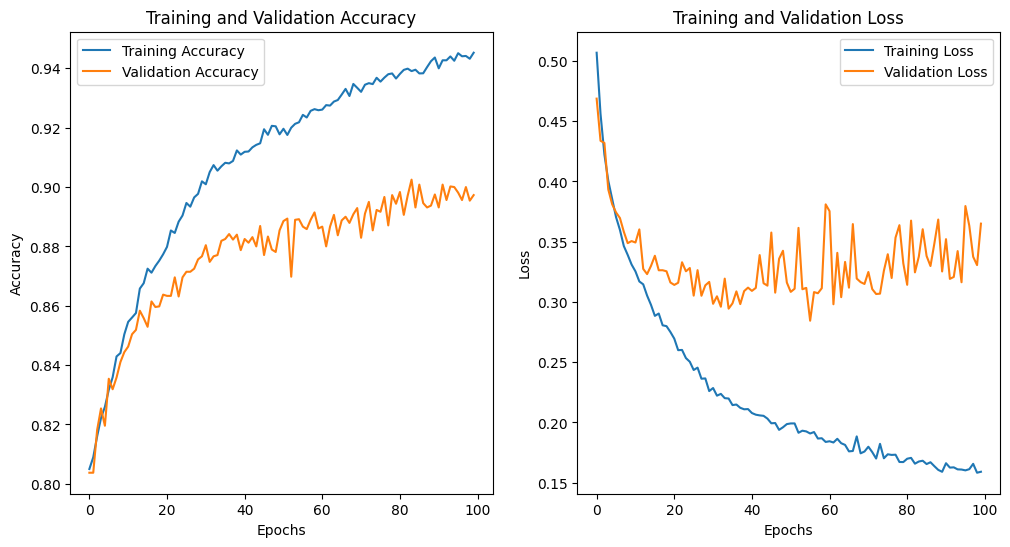

Test Accuracy: 0.8972916603088379, Test Loss: 0.36499708890914917


In [6]:
import matplotlib.pyplot as plt
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()
print(f'Test Accuracy: {test_accuracy}, Test Loss: {test_loss}')

### Score 

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

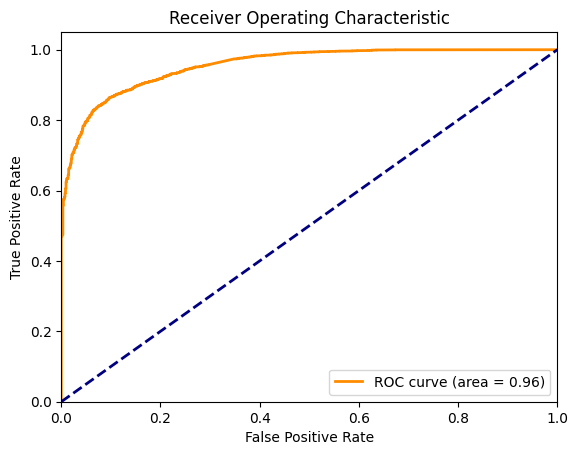

In [22]:
y_pred = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [23]:
cm = confusion_matrix(y_test, (y_pred > 0.5).astype(int))

print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, (y_pred > 0.5).astype(int)))

Confusion Matrix:
[[ 685  257]
 [ 188 3670]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.73      0.75       942
           1       0.93      0.95      0.94      3858

    accuracy                           0.91      4800
   macro avg       0.86      0.84      0.85      4800
weighted avg       0.91      0.91      0.91      4800



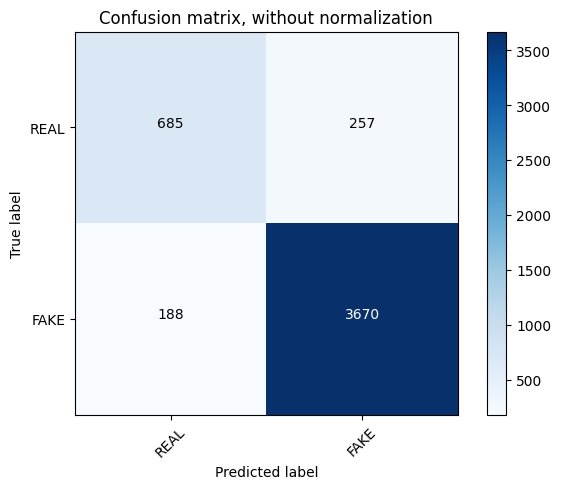

In [24]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, (y_pred > 0.5).astype(int))
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools  # Import the itertools module

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['REAL', 'FAKE']

# Generate the confusion matrix
cm = confusion_matrix(y_test, (y_pred > 0.5).astype(int))

# Plot the confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix, without normalization')
plt.show()

In [26]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 126, 126, 256)     7168      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 63, 63, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 61, 61, 128)       295040    
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 30, 30, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 28, 28, 64)        73792     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 14, 14, 64)      

In [12]:
# Save the model
model.save('deepfake_detection_cnn.h5')

/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
model.save_weights("weight_cnn.h5")

In [ ]:
from keras.preprocessing import image
import numpy as np

# Load the image for testing
img_path = r'C:\sahiti\Sem5\ML\ML Project\Pro\frame_25.jpg'
img = image.load_img(img_path, target_size=(128, 128))  # Adjust target_size based on your model's input shape
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalize the pixel values to the range [0, 1] if your model expects that

# Make predictions
predictions = model.predict(img_array)

# Display the predictions
if predictions[0][0] > 0.5:
    print("Predicted: Real")
else:
    print("Predicted: Fake")